### Rewrite dlnd_project2 in kur
- [original project_2 code](http://nbviewer.jupyter.org/github/EmbraceLife/image_classification_dlnd2/blob/master/cnn_cifar10.ipynb#annotations:5YK7tv1dEealzwMjXZx4WQ) in tensorflow
- [detailed outline](https://github.com/EmbraceLife/image_classification_dlnd2/blob/master/outline.md) of the original code
- kur code to replicate the original code is below

In [9]:
!kur --version

Kur, by Deepgram -- deep learning made easy
Version: 0.3.0
Homepage: https://kur.deepgram.com


In [12]:
%%writefile dlnd_p2.yml

---
settings:

  # Where to get the data
  cifar: &cifar
    url: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    checksum: "6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce"
    path: "~/kur"           # if kur does not have normalization or one-hot-encoding, ##################
                            # without normalization and one-hot-encoding, the performance will be hurt, right? ####
  # Backend to use                                      
  backend:
    name: keras

  # Hyperparameters
  cnn:
    kernels: 20
    size: [5, 5]
    strides: [2, 2]                

  pool:
    size: [2,2]
    strides: [2,2]
    type: "max"                         # must use a string here, {max} won't work, doc didn't say it #############

model:
  - input: images                       # images are normalized from 0 to 1, labels are one-hot-encoding ##########
  - convolution:                        # does kur do normalize and one-hot-encoding under the hood? ##############
      kernels: "{{cnn.kernels}}"
      size: "{{cnn.size}}"
      strides: "{{ cnn.strides }}"
  - activation: relu
  - pool:
      size: "{{pool.size}}"
      strides: "{{pool.strides}}"
      type: "{{pool.type}}"             
  - flatten:
  - dense: 15                           # p2 want a dropout applied here, but kur does not have yet?? ############
#   - dropout: 0.75
  - dense: 10
  - activation: softmax
    name: labels

train:
  data:
    - cifar:
        <<: *cifar
        parts: [1]                      # only use dataset part 1 to train
  provider:
    batch_size: 128
    num_batches: 1000                   # the entire part 1 will be used
  log: t3/cifar-log                   
  epochs: 20
  weights:
    initial: t3/cifar.best.valid.w    
    best: t3/cifar.best.train.w
    last: t3/cifar.last.w

  optimizer:
    name: adam
    learning_rate: 0.001

validate:
  data:
    - cifar:
       <<: *cifar
       parts: 5                          # only use dataset part 5 as validation set
  provider:
    num_batches: 50                      # the project 2 only used 5000 data points as validation set
  weights: t3/cifar.best.valid.w

test: &test
  data:
    - cifar:
       <<: *cifar
       parts: test
  weights: t3/cifar.best.valid.w
  provider:
    num_batches: 1000                     # the entire part test will be used

evaluate:
  <<: *test
  destination: t3/cifar.results.pkl

loss:
  - target: labels                        # in the project: training loss and valid_accuracy are printed #############
    name: categorical_crossentropy        # this should be a matter of personal taste, won't really affect anything##
...


Overwriting dlnd_p2.yml


In [13]:
%pwd

'/Users/Natsume/Downloads/kur_road'

In [14]:
%ls

Kur_Road.ipynb       dlnd_p2_dropout.yml  t1/
cifar-log/           dlnd_p2_kur.ipynb    t2/
dlnd_p2.yml          kur/                 t3/


In [15]:
!kur -v train dlnd_p2.yml

[INFO 2017-02-28 22:28:48,972 kur.kurfile:638] Parsing source: dlnd_p2.yml, included by top-level.
[INFO 2017-02-28 22:28:48,989 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-28 22:28:49,038 kur.loggers.binary_logger:87] Log does not exist. Creating path: t3/cifar-log
[INFO 2017-02-28 22:28:56,014 kur.providers.batch_provider:54] Batch size set to: 128
[INFO 2017-02-28 22:28:56,014 kur.providers.batch_provider:60] Maximum number of batches set to: 1000
[INFO 2017-02-28 22:29:02,413 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-28 22:29:02,413 kur.providers.batch_provider:60] Maximum number of batches set to: 50
[INFO 2017-02-28 22:29:02,414 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-28 22:29:02,414 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-28 22:29:02,414 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-02-28 22:29:03,578 kur.backend.keras_backend:191] Keras is loaded. The backe

In [22]:
# %cd t3/
!ls cifar-log

training_loss_labels   validation_loss_labels
training_loss_total    validation_loss_total


In [23]:
from kur.loggers import BinaryLogger
training_loss = BinaryLogger.load_column('cifar-log', 'training_loss_total') 
validation_loss = BinaryLogger.load_column('cifar-log', 'validation_loss_total') 
 
training_loss

array([ 2.0347259 ,  1.6929394 ,  1.54147506,  1.44420362,  1.3758949 ,
        1.31863678,  1.26508343,  1.2262063 ,  1.18933189,  1.15463436,
        1.12429321,  1.09335482,  1.06431651,  1.04932415,  1.02948546,
        0.99968618,  0.98606402,  0.9677121 ,  0.96266526,  0.93041307], dtype=float32)

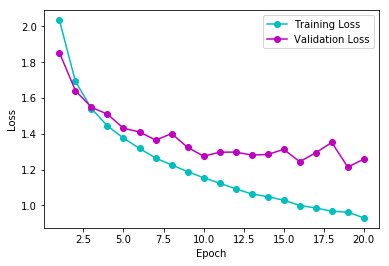

In [24]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch')
plt.ylabel('Loss')
epoch = list(range(1, 1+len(training_loss)))
t_line, = plt.plot(epoch, training_loss, 'co-', label='Training Loss')
v_line, = plt.plot(epoch, validation_loss, 'mo-', label='Validation Loss')
plt.legend(handles=[t_line, v_line])
plt.show()

In [10]:
%%writefile dlnd_p2_dropout.yml

---
settings:

  # Where to get the data
  cifar: &cifar
    url: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    checksum: "6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce"
    path: "~/kur"           # if kur does not have normalization or one-hot-encoding, ##################
                            # without normalization and one-hot-encoding, the performance will be hurt, right? ####
  # Backend to use                                      
  backend:
    name: keras

  # Hyperparameters
  cnn:
    kernels: 20
    size: [5, 5]
    strides: [2, 2]                

  pool:
    size: [2,2]
    strides: [2,2]
    type: "max"                         # must use a string here, {max} won't work, doc didn't say it #############

model:
  - input: images                       # images are normalized from 0 to 1, labels are one-hot-encoding ##########
  - convolution:                        # does kur do normalize and one-hot-encoding under the hood? ##############
      kernels: "{{cnn.kernels}}"
      size: "{{cnn.size}}"
      strides: "{{ cnn.strides }}"
  - activation: relu
  - pool:
      size: "{{pool.size}}"
      strides: "{{pool.strides}}"
      type: "{{pool.type}}"             
  - flatten:
  - dense: 15                           # p2 want a dropout applied here, but kur does not have yet?? ############
  - dropout: 0.75
  - dense: 10
  - activation: softmax
    name: labels

train:
  data:
    - cifar:
        <<: *cifar
        parts: [1]                      # only use dataset part 1 to train
  provider:
    batch_size: 128
    num_batches: 1000                   # the entire part 1 will be used
  log: t3/cifar-log                   
  epochs: 20
  weights:
    initial: t3/cifar.best.valid.w    
    best: t3/cifar.best.train.w
    last: t3/cifar.last.w

  optimizer:
    name: adam
    learning_rate: 0.001

validate:
  data:
    - cifar:
       <<: *cifar
       parts: 5                          # only use dataset part 5 as validation set
  provider:
    num_batches: 50                      # the project 2 only used 5000 data points as validation set
  weights: t3/cifar.best.valid.w

test: &test
  data:
    - cifar:
       <<: *cifar
       parts: test
  weights: t3/cifar.best.valid.w
  provider:
    num_batches: 1000                     # the entire part test will be used

evaluate:
  <<: *test
  destination: t3/cifar.results.pkl

loss:
  - target: labels                        # in the project: training loss and valid_accuracy are printed #############
    name: categorical_crossentropy        # this should be a matter of personal taste, won't really affect anything##
...


Writing dlnd_p2_dropout.yml


In [11]:
!kur -v train dlnd_p2_dropout.yml

[INFO 2017-02-28 22:28:36,640 kur.kurfile:638] Parsing source: dlnd_p2_dropout.yml, included by top-level.
[INFO 2017-02-28 22:28:36,658 kur.kurfile:79] Parsing Kurfile...
Traceback (most recent call last):
  File "/Users/Natsume/miniconda2/envs/dlnd-tf-lab/bin/kur", line 11, in <module>
    sys.exit(main())
  File "/Users/Natsume/miniconda2/envs/dlnd-tf-lab/lib/python3.5/site-packages/kur/__main__.py", line 269, in main
    sys.exit(args.func(args) or 0)
  File "/Users/Natsume/miniconda2/envs/dlnd-tf-lab/lib/python3.5/site-packages/kur/__main__.py", line 47, in train
    spec = parse_kurfile(args.kurfile, args.engine)
  File "/Users/Natsume/miniconda2/envs/dlnd-tf-lab/lib/python3.5/site-packages/kur/__main__.py", line 40, in parse_kurfile
    spec.parse()
  File "/Users/Natsume/miniconda2/envs/dlnd-tf-lab/lib/python3.5/site-packages/kur/kurfile.py", line 120, in parse
    self.engine, builtin['model'], stack, required=True)
  File "/Users/Natsume/miniconda2/envs/dlnd-tf-lab/lib/python